<a id='section_id0'></a>
# Data Programming Essentials *with Python*

## Part 3 Modeling 2 : Logistic Regression

<font color="#740202">**Table of contents:**

|No.|Topic||No.|Topic||No.|Topic|
|:------|:------||:------|:------||:------|:------|
|1.|[Key Libraries](#section_id1)||2.|[Sleeping dataset ](#section_id3)  |
|3.|[Logit with Statsmodels](#section_id4)  ||4.|[Logit with Scikit](#section_id5)  ||5.|[K-fold Cross Validation](#section_id6)  |
|6.|[Variable selection approaches](#section_id7)  ||7.|[Logit Regularization](#section_id8)||8.|[Nominal Logit](#section_id9)|
|9.|[Ordinal Logit](#section_id10)  ||10.|[References](#section_id11)||||

***

<a id='section_id1'></a>
### <span style="background-color:#B0E0E6">Key libraries</span>
* The following are the main libraries we'll use for modeling with logistic regression:
* [Statsmodels](https://www.statsmodels.org/stable/index.html)
    * This library is suitable when your main goal for analysis is "explanation". It provides easy reference to a host of statistics that can help with hypothesis testing exercises. 
* [Scikit-learn](https://scikit-learn.org/stable/index.html)
    * This is a very popular package for machine learning in Python. Compiling explanation-oriented statistics is a little cumbersome with this package, but it provides powerful tools for prediction-oriented analysis.
* [DMBA](https://pypi.org/project/dmba/)
    * This is the set of utilities associated with the reference book I suggested: [Data Mining for Business Analytics](https://www.dataminingbook.com/book/python-edition)
    * You can freely access the book and download individual PDF book chapters through the [Pitt library](https://pitt.summon.serialssolutions.com/#!/search?bookMark=ePnHCXMw42JgAfZbU5khpymBDxSztADNrHEZgbYtA2tc0K0CXMBq3gRYkwA7SJwMSi6JJYkKueALERSATTUF6P2LxQqJoIM5QMcV8zCwpgGjI5WXgaWkqBRYcEq7uYY4e-iCDkeKhw50xAPTkpmJBejiIfyyKlhkYXM9QGVA95qYGQMA-383uA)
    * Logistic regression is covered in chapter 10 of the DMBA book.

In [48]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# for regressions with statsmodels:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# for regressions with scikit-learn:
import sklearn.linear_model as sklm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for plotting confusion matrix:
!pip install scikit-plot
import scikitplot as skplt

#for ordinal logistic regression
!pip install mord
from mord import LogisticIT


In [49]:
#These are utility tools of the DMBA book. 
#Install the "dmba" package first (just one time)

!pip install dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

In [50]:
# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (6, 5))

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id3'></a>
### <span style="background-color:#B0E0E6">Sleeping duration data: check and explore</span>

|Variable|Description|
|:------|:------|
|sleeping|sleep hours on an average shcool night: 1=<4 hrs, 2=5 hrs, 3=6 hrs, 4=7 hrs, 5=8 hrs, 6=9 hrs, 7= >=10 hrs|
|sex|1=Female, 2=Male|
|race|1=White, 2=Black or African American, 3=Hispanic/Latino, 4=All other races|
|sexharass|sexual harassment during the past 12 months: 1=0 times, 2=1 time, 3=2 or 3 times, 4=4 or 5 times, 5=6 or more times|
|smoking|smoke cigarettes during the past 30 days: 1=0 days, 2=1 or 2 days, 3=3 to 5 days, 4= 6 to 9 days, 5=10 to 19 days, 6=20 to 29 days, 7=all 30 days|
|vegetables|eating other vegetables(do not count green salad, potatoes, or carrots) during the past 7 days: 1=0 times, 2=1 to 3 times, 3=4 to 6 times, 4=1 time/day, 5=2 times/day, 6=3 times/day, 7=>= 4 times/day|
|soda|drinking soda or pop during past 7 days: 1= 0 times, 2=1 to 3 times, 3=4 to 6 times, 4=1 time/day, 5=2 times/day, 6=3 times/day, 7=>=4 times/day |
|breakfast|days of eating breakfast per week: 1=0 day, 2=1 day, 3=2 days, 4=3 days, 5= 4 days, 6=5 days, 7=6 days, 8= 7 days|
|computer|hours of playing computer games or something that is not school work per day: 1=0 hrs, 2=<1 hr, 3=1 hr, 4=2 hrs, 5=3 hrs, 6=4 hrs, 7=>=5 hrs|


In [51]:
df1 = pd.read_csv('sleeping.csv')

In [52]:
df1.describe()

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer
count,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000
mean,3.508007,1.481336,2.064633,1.186554,1.250028,2.556102,2.410574,5.098896,3.930204
std,1.398969,0.499658,1.226763,0.631294,0.988877,1.360694,1.490681,2.657106,2.191636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,5.000000,4.000000
75%,4.000000,2.000000,3.000000,1.000000,1.000000,3.000000,3.000000,8.000000,6.000000
max,7.000000,2.000000,4.000000,5.000000,7.000000,7.000000,7.000000,8.000000,7.000000


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36220 entries, 0 to 36219
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   sleeping    36220 non-null  int64
 1   sex         36220 non-null  int64
 2   race        36220 non-null  int64
 3   sexharass   36220 non-null  int64
 4   smoking     36220 non-null  int64
 5   vegetables  36220 non-null  int64
 6   soda        36220 non-null  int64
 7   breakfast   36220 non-null  int64
 8   computer    36220 non-null  int64
dtypes: int64(9)
memory usage: 2.5 MB


In [54]:
df1.isna().sum().sum()

0

In [55]:
# inserting a sleep_category column

df1['sleepcat']=pd.cut(df1['sleeping'], bins=[0,4,8], labels=['0', '1']) # 0 = short, 0 =long
df1.head(6)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
0,1,2,4,4,4,3,2,3,3,0
1,1,2,3,1,1,2,1,1,2,0
2,1,2,4,1,1,1,1,1,1,0
3,3,2,4,1,1,3,5,5,4,0
4,3,2,4,1,6,2,6,5,7,0
5,5,2,4,1,1,5,2,4,5,1


In [56]:
df1.isna().sum().sum()

0

In [10]:
# check if the cut is correct
df1.loc[df1.sleeping>=5].head(10)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
5,5,2,4,1,1,5,2,4,5,1
6,6,2,4,1,1,3,1,8,7,1
8,6,2,1,1,1,3,3,1,4,1
10,6,2,1,1,1,6,2,8,6,1
11,5,2,1,1,1,1,2,7,2,1
15,5,2,1,1,1,1,3,8,4,1
24,7,2,1,1,1,2,3,8,7,1
28,5,2,2,2,1,3,2,8,1,1
29,5,2,1,2,1,5,4,8,5,1
30,5,2,2,1,1,2,3,2,1,1


In [11]:
df1.loc[df1.sleeping<5].head(10)

,sleeping,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
0,1,2,4,4,4,3,2,3,3,0
1,1,2,3,1,1,2,1,1,2,0
2,1,2,4,1,1,1,1,1,1,0
3,3,2,4,1,1,3,5,5,4,0
4,3,2,4,1,6,2,6,5,7,0
7,4,2,1,1,1,2,1,3,6,0
9,2,2,3,1,1,5,2,8,4,0
12,1,2,2,1,1,1,2,1,1,0
13,4,2,3,1,1,1,1,8,6,0
14,1,2,3,1,1,1,1,1,1,0


In [57]:
df1.drop(columns=['sleeping'], inplace=True)
df1.columns

Index(['sex', 'race', 'sexharass', 'smoking', 'vegetables', 'soda',
       'breakfast', 'computer', 'sleepcat'],
      dtype='object')

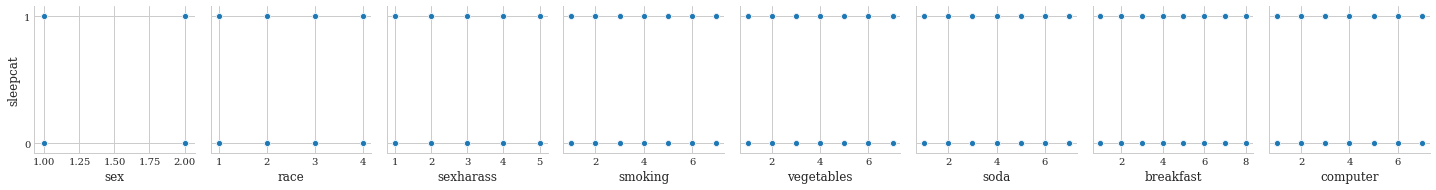

In [13]:
sns.pairplot(data=df1, y_vars=['sleepcat'], x_vars=['sex', 'race', 'sexharass', 'smoking','vegetables', 'soda', 'breakfast', 'computer'])

In [58]:
# converting the data types using functions like `.astype(int)` or `pd.to_numeric()`.
df1.loc[:,'sleepcat']=pd.to_numeric(df1.loc[:,'sleepcat'], errors='coerce')

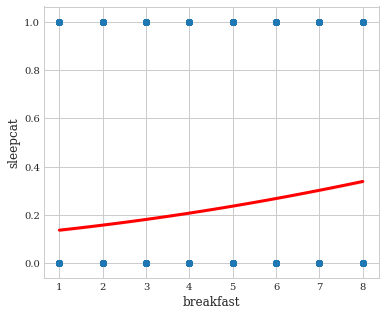

In [15]:
sns.regplot(x="breakfast", y="sleepcat", data=df1, logistic=True, line_kws={"color": "red"})

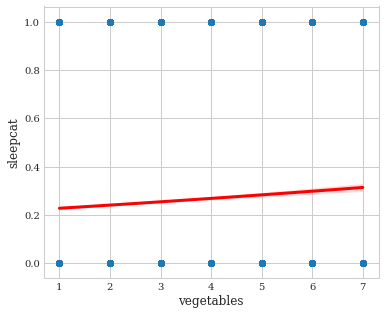

In [16]:
sns.regplot(x="vegetables", y="sleepcat", data=df1, logistic=True, line_kws={"color": "red"})

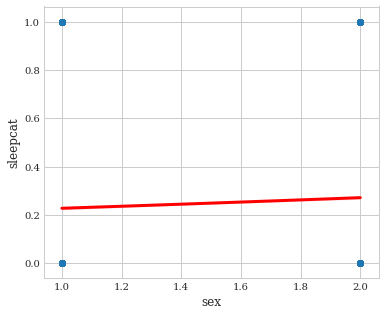

In [17]:
sns.regplot(x="sex", y="sleepcat", data=df1, logistic=True, line_kws={"color": "red"})

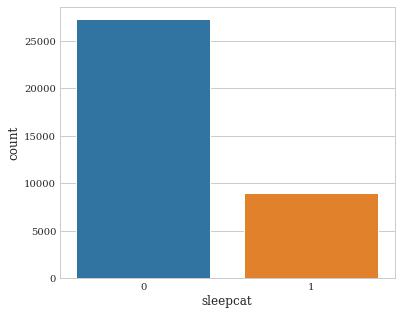

In [18]:
sns.countplot(x='sleepcat', data=df1)

* There are more short sleep duration than sufficient sleep duration.

In [19]:
df1.corr()

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat
sex,1.000000,-0.008730,-0.131154,0.031740,-0.011861,0.110614,0.060118,0.034058,0.050883
race,-0.008730,1.000000,0.014876,-0.029708,-0.022442,-0.052377,-0.037561,0.025410,-0.038761
sexharass,-0.131154,0.014876,1.000000,0.146019,0.024699,0.051952,-0.084936,0.017453,-0.048171
smoking,0.031740,-0.029708,0.146019,1.000000,0.003918,0.173174,-0.089880,-0.016917,-0.047008
vegetables,-0.011861,-0.022442,0.024699,0.003918,1.000000,-0.014684,0.157419,-0.033184,0.044287
soda,0.110614,-0.052377,0.051952,0.173174,-0.014684,1.000000,-0.087709,0.132579,-0.035172
breakfast,0.060118,-0.037561,-0.084936,-0.089880,0.157419,-0.087709,1.000000,-0.001090,0.181771
computer,0.034058,0.025410,0.017453,-0.016917,-0.033184,0.132579,-0.001090,1.000000,-0.061850
sleepcat,0.050883,-0.038761,-0.048171,-0.047008,0.044287,-0.035172,0.181771,-0.061850,1.000000


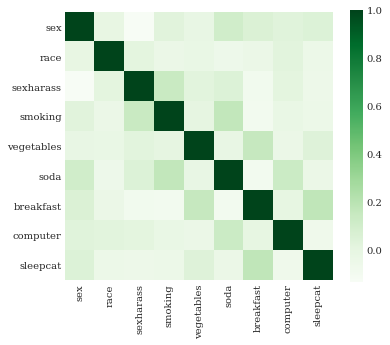

In [20]:
# Draw a correlation heatmap 
corrmat = df1.corr()
sns.heatmap(corrmat, square = True, cmap="Greens")

In [59]:
# inserting a sleep_category column

df1['racecat']=pd.cut(df1['race'], bins=[0,2,5], labels=['1', '0']) # 1 = white, 0 =nonwhite
df1.head(6)

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat,racecat
0,2,4,4,4,3,2,3,3,0,0
1,2,3,1,1,2,1,1,2,0,0
2,2,4,1,1,1,1,1,1,0,0
3,2,4,1,1,3,5,5,4,0,0
4,2,4,1,6,2,6,5,7,0,0
5,2,4,1,1,5,2,4,5,1,0


In [60]:
df1.loc[df1.race>1].head()

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat,racecat
0,2,4,4,4,3,2,3,3,0,0
1,2,3,1,1,2,1,1,2,0,0
2,2,4,1,1,1,1,1,1,0,0
3,2,4,1,1,3,5,5,4,0,0
4,2,4,1,6,2,6,5,7,0,0


In [61]:
df1.loc[df1.race==1].head()

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat,racecat
7,2,1,1,1,2,1,3,6,0,1
8,2,1,1,1,3,3,1,4,1,1
10,2,1,1,1,6,2,8,6,1,1
11,2,1,1,1,1,2,7,2,1,1
15,2,1,1,1,1,3,8,4,1,1


In [62]:
# converting the data types using functions like `.astype(int)` or `pd.to_numeric()`.
df1.loc[:,'racecat']=pd.to_numeric(df1.loc[:,'racecat'], errors='coerce')

In [63]:
# Treat education as categorical, convert to dummy variables
df1['racecat'] = df1['racecat'].astype('category')
new_categories = {0: 'nonwhite', 1: 'white'}
df1.racecat.cat.rename_categories(new_categories, inplace=True)
df1 = pd.get_dummies(df1, prefix_sep='_', drop_first=True)

In [64]:
df1.head(3)

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat,racecat_white
0,2,4,4,4,3,2,3,3,0,0
1,2,3,1,1,2,1,1,2,0,0
2,2,4,1,1,1,1,1,1,0,0


In [26]:
# inserting a sleep_category column

#df1['vegcat']=pd.cut(df1['vegetables'], bins=[0,1,8], labels=['0', '1']) # 0 = no, 1 =yes
#df1.head(6)

In [27]:
#df1.loc[df1.vegetables==1].head(3)

In [28]:
#df1.loc[df1.vegetables>=2].head(3)

In [29]:
# Treat education as categorical, convert to dummy variables
#df1['vegcat'] = df1['vegcat'].astype('category')
#new_categories = {0: 'No', 1: 'Yes'}
#df1.vegcat.cat.rename_categories(new_categories, inplace=True)
#df1 = pd.get_dummies(df1, prefix_sep='_', drop_first=True)

In [30]:
#df1.head(3)

In [31]:
# inserting a sleep_category column

#df1['smokecat']=pd.cut(df1['smoking'], bins=[0,1,9], labels=['0', '1']) # 0 = no, 1 =yes
#df1.head(6)

In [32]:
#df1.loc[df1.smoking>=2].head(3)

In [33]:
#df1.loc[df1.smoking<2].head(3)

In [34]:
# Treat education as categorical, convert to dummy variables
#df1['smokecat'] = df1['smokecat'].astype('category')
#new_categories = {0: 'No', 1: 'Yes'}
#df1.smokecat.cat.rename_categories(new_categories, inplace=True)
#df1 = pd.get_dummies(df1, prefix_sep='_', drop_first=True)

In [35]:
#df1.head(3)

In [36]:
# inserting a sleep_category column

#df1['sexharcat']=pd.cut(df1['sexharass'], bins=[0,1,6], labels=['0', '1']) # 0 = no, 1 =yes
#df1.head(6)

In [37]:
#df1.loc[df1.sexharass<2].head(3)

In [38]:
#df1.loc[df1.sexharass>=2].head(3)

In [39]:
# Treat education as categorical, convert to dummy variables
#df1['sexharcat'] = df1['sexharcat'].astype('category')
#new_categories = {0: 'No', 1: 'Yes'}
#df1.sexharcat.cat.rename_categories(new_categories, inplace=True)
#df1 = pd.get_dummies(df1, prefix_sep='_', drop_first=True)

In [40]:
#df1.head(6)

In [41]:
#df1.drop(columns=['race','sexharass', 'smoking', 'vegetables'])

In [44]:
df1.head(3)

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat,racecat_0
0,2,4,4,4,3,2,3,3,0,1
1,2,3,1,1,2,1,1,2,0,1
2,2,4,1,1,1,1,1,1,0,1


In [43]:
df1.isna().sum().sum()

0

In [65]:
df1['racecat_white'].unique()

array([0, 1], dtype=uint8)

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id4'></a>
### <span style="background-color:#B0E0E6">Logit with Statsmodels</span>

In [66]:
df2 = sm.add_constant(df1, prepend=True) # add constant column
y = df2['sleepcat']
X = df2.drop(columns=['sleepcat', 'race'])
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [67]:
# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               sleepcat   No. Observations:                21732
Model:                            GLM   Df Residuals:                    21723
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11680.
Date:                Tue, 14 Jul 2020   Deviance:                       23359.
Time:                        17:45:49   Pearson chi2:                 2.18e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8715      0.089    -21.089      0.000      -2.045      -1.698
sex               0.1657      0.033      5.057      0.000       0.101       0.230
sexharass        -0.1153      0.030     -3.833      0.000      -0.174      -0.056
smoking          -0.0788      0.020     -3.991      0.000      -0.118      -0.040
vegetables        0.0389      0.012      3.315      0.001       0.016       0.062
soda             -0.0225      0.012     -1.951      0.051      -0.045       0.000
breakfast         0.1543      0.007     23.702      0.000       0.142       0.167
computer         -0.0595      0.008     -7.881      0.000      -0.074      -0.045
racecat_white     0.1307      0.033      3.909      0.000       0.065       0.196
=================================================================================
"""

* race_1=white: nonwhite students sleep less.
* students who eat vegetables sleep more than those don't eat vegetables.
* students who smoke cigarettes sleep less than those don't smoke cigarettes.
* students who had sexual harrasments sleep less than those who don't.

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id5'></a>
### <span style="background-color:#B0E0E6">Logit with Scikit-Learn</span>

In [72]:
#Set up:
y = df1['sleepcat']
X = df1.drop(columns=['sleepcat', 'race'])
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X, y, test_size=0.4, random_state=1)
print(train_X2.shape, train_y2.shape)
print(train_X2.shape, valid_y2.shape)

(21732, 8) (21732,)
(21732, 8) (14488,)


In [73]:
lreg=sklm.LogisticRegression(solver='liblinear')
lreg.fit(train_X2, train_y2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

The coefficient parameters can be different across the different solvers. The scikit estimates are different from statsmodels:

In [74]:
lreg.intercept_[0]

-1.8560900297337835

In [75]:
pd.DataFrame({'coefficients': lreg.coef_[0]}, index=X.columns)

,coefficients
sex,0.162543
sexharass,-0.117440
smoking,-0.079422
vegetables,0.038342
soda,-0.022869
breakfast,0.153832
computer,-0.059826
racecat_white,0.129126


In [76]:
#get the predicted values in training:
lreg_predictions_tr=lreg.predict(train_X2)
lreg_predictions_tr[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [77]:
#get the predicted probabilities in training:
lreg_predict_prob_tr=lreg.predict_proba(train_X2) # predictions for training set as probability values
lreg_predict_prob_tr

array([[0.68450929, 0.31549071],
       [0.88334375, 0.11665625],
       [0.66465071, 0.33534929],
       ...,
       [0.63929003, 0.36070997],
       [0.84871974, 0.15128026],
       [0.85538402, 0.14461598]])

In [78]:
logit_result_tr = pd.DataFrame({'actual': train_y2, 
                             'p(0)': [p[0] for p in lreg_predict_prob_tr],
                             'p(1)': [p[1] for p in lreg_predict_prob_tr],
                             'predicted': lreg_predictions_tr })

In [79]:
# highest probability of having sufficient sleep:
logit_result_tr.sort_values(by='p(1)', ascending=False).head()

,actual,p(0),p(1),predicted
18852,1,0.545471,0.454529,0
18869,0,0.545471,0.454529,0
5108,0,0.545471,0.454529,0
3837,0,0.545471,0.454529,0
19367,1,0.545471,0.454529,0


In [80]:
#lowest probability of getting sufficient sleep:
logit_result_tr.sort_values(by='p(1)').head()

,actual,p(0),p(1),predicted
5210,0,0.961705,0.038295,0
19608,0,0.961705,0.038295,0
29032,0,0.961705,0.038295,0
25948,0,0.961705,0.038295,0
25382,0,0.958190,0.041810,0


In [81]:
# This is the confusion matrix from DMBA book package
classificationSummary(train_y2, lreg_predictions_tr)

Confusion Matrix (Accuracy 0.7542)

       Prediction
Actual     0     1
     0 16390     0
     1  5342     0


In [82]:
# This is a utility from scikit
cm = confusion_matrix(train_y2, lreg_predictions_tr)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[16390     0]
 [ 5342     0]]


In [83]:
# This is a utility from scikit
print("Classification Report:\n",classification_report(train_y2, lreg_predictions_tr))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86     16390
           1       0.00      0.00      0.00      5342

    accuracy                           0.75     21732
   macro avg       0.38      0.50      0.43     21732
weighted avg       0.57      0.75      0.65     21732



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Notes:
* From the [clasification report documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
    * The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label).
    * macro: calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    * weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall. 

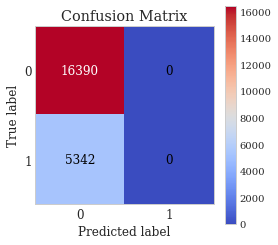

In [84]:
# You can plot the confusion matrix:
skplt.metrics.plot_confusion_matrix(train_y2, lreg_predictions_tr, figsize=(4,4), cmap="coolwarm")

<Mark>Interpretation:</Mark> We see that the model resulted in 75% accuracy of classifying sleeping duration. none of the 5342 with sufficient sleep were correctly identified by the model. It missed 5342 others who had sufficient sleep, and wrongly identifed nobody as worthy of approval.<br>

The classification report produces various other metrics. Here are some additional, easy-to-understand resources for shedding light on them:
* Wikipedia has a nice page on the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) with all the formulas for the metrics
* [A discussion of the metrics presented](https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn) in the classification report.
* [A discussion of the "avg" values](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001) presented in the matrix.

In [85]:
# How good is the model on the validation dataset?
lreg_predictions_tt=lreg.predict(valid_X2)

In [86]:
print("Classification Report:\n",classification_report(valid_y2, lreg_predictions_tt))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86     10842
           1       0.00      0.00      0.00      3646

    accuracy                           0.75     14488
   macro avg       0.37      0.50      0.43     14488
weighted avg       0.56      0.75      0.64     14488



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


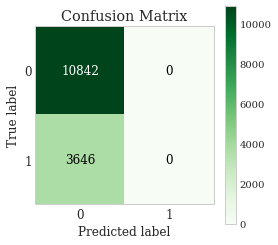

In [87]:
skplt.metrics.plot_confusion_matrix(valid_y2, lreg_predictions_tt, figsize=(4,4), cmap="Greens")

<Mark>Interpretation:</Mark> We see that the model resulted in 75% accuracy of classifying students having sufficient sleep. None of the 3646 customers with approvals were correctly identified by the model. It missed 3646 others who were approved, and wrongly identifed noobody who have insifficient sleep.<br>

In [88]:
lreg_predictions_tt.shape

(14488,)

#### What about a naive prediction?

In [89]:
1-df1.sleepcat.mean() #for the whole dataset of 5000 customers

0.7518498067366096

In [90]:
1-valid_y2.mean() #for the validation dataset of 14488 customers

0.7483434566537824

In [91]:
naiveprediction = [0] * 14488

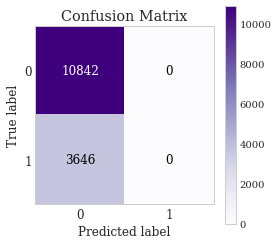

In [92]:
skplt.metrics.plot_confusion_matrix(valid_y2, naiveprediction, figsize=(4,4), cmap="Purples")

In [93]:
print("Classification Report:\n",classification_report(valid_y2, naiveprediction))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86     10842
           1       0.00      0.00      0.00      3646

    accuracy                           0.75     14488
   macro avg       0.37      0.50      0.43     14488
weighted avg       0.56      0.75      0.64     14488



<Mark>Interpretation:</Mark> Clearly, the naive prediction has almost the same accuracy as our model, and it is not helpful in practice. 

#### Gain and lift charts

* Gains refers to the the total number or percentage of cases of interest identified by a model
* Lift refers to the ratio of such cases to those found through random selection

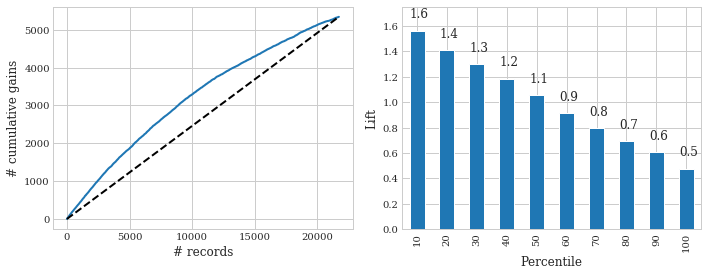

In [94]:
dfgains = logit_result_tr.sort_values(by='p(1)', ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(dfgains.actual, ax=axes[0])
liftChart(dfgains['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

#### Manually chaning the cutoff for classification

Text(0, 0.5, 'Frequency')

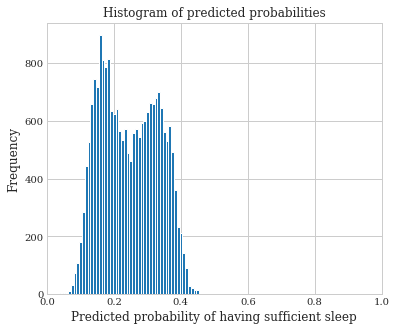

In [95]:
# Exploring the probabilities of purchase predicted by the logistic regression model:
plt.hist(lreg_predict_prob_tr[:,1], bins=50)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of having sufficient sleep')
plt.ylabel('Frequency')

In [96]:
# if we cut the probability values into "sufficient-yes" or "insufficient-no" at 20%:
ypredclass_tr2 = np.where(lreg_predict_prob_tr[:,1] > 0.2, 1, 0)

In [97]:
cm2 = confusion_matrix(train_y2, ypredclass_tr2)
print("Confusion Matrix:\n", cm)
print("\n")
print("Classification Report:\n",classification_report(train_y2, ypredclass_tr2))

Confusion Matrix:
 [[16390     0]
 [ 5342     0]]


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.41      0.55     16390
           1       0.30      0.76      0.43      5342

    accuracy                           0.50     21732
   macro avg       0.57      0.59      0.49     21732
weighted avg       0.71      0.50      0.52     21732



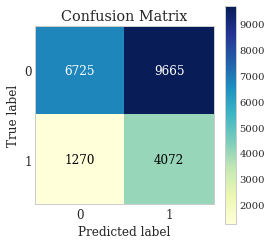

In [98]:
skplt.metrics.plot_confusion_matrix(train_y2, ypredclass_tr2, figsize=(4,4), cmap="YlGnBu")

<Mark>Interpretation:</Mark> After tweaking the cutoff, we see that the model's accuracy has decreased to 50%. More people (4074 as compared to previous 0) are identified correctly as accepting personal loans, but more mistakes are also being made (9673 as compared to the previous 0).<br>

The Receiver operating characteristic (ROC) curve shows how the performance of the classifier varies to different cutoffs. A higher area under the curve indicates a better model.

Area under the curve (AUC):
 0.5862862453455173


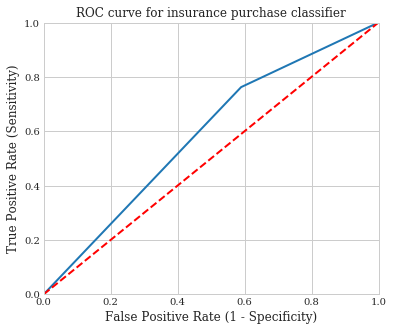

In [99]:
#higher AUC indicates better classifier
fpr, tpr, thresholds = roc_curve(train_y2, ypredclass_tr2)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.title('ROC curve for insurance purchase classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
print("Area under the curve (AUC):\n", roc_auc_score(train_y2, ypredclass_tr2))

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id6'></a>
### <span style="background-color:#B0E0E6">K-fold Cross Validation</span>

In [100]:
# How good is the model if subjected to variations in the training sample?
cvparam = KFold(10, random_state=13)
scores_accuracy_lgrcv_tr =  cross_validate(lreg, valid_X2, valid_y2, cv=cvparam, scoring='accuracy')

C:\Users\edwar\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [101]:
scores_accuracy_lgrcv_tr

{'fit_time': array([0.07878423, 0.06704998, 0.06632042, 0.06029296, 0.07334566,
        0.06556225, 0.06399322, 0.06547308, 0.06489253, 0.06466651]),
 'score_time': array([0.00164104, 0.        , 0.        , 0.        , 0.0010407 ,
        0.        , 0.        , 0.        , 0.00806093, 0.        ]),
 'test_score': array([0.73775017, 0.74534161, 0.75569358, 0.74396135, 0.76397516,
        0.75362319, 0.73982057, 0.73567978, 0.74654696, 0.76104972])}

In [102]:
scores_accuracy_lgrcv_tr['test_score'].mean()

0.7483442095710892

<Mark>Interpretation:</Mark> The crossvalidated model produces almost no improvement in terms of accuracy over the naive benchmark (no body will have sufficient sleep).

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id7'></a>
### <span style="background-color:#B0E0E6">Variable Selection Approaches</span>

#### Exhaustive search
* We'll use the Akaike Information Criteria (AIC) to pick among the models with different subsets of predictor variables. Bayesian Information Criteria (BIC) can also be used.
* Use a function from the DMBA package for implementing exhaustive search.

In [103]:
def train_model(variables):
    model = sklm.LogisticRegression(solver='liblinear')
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return AIC_score(train_y, pred_y, model)

In [104]:
allVariables = train_X2.columns
results = exhaustive_search(allVariables, train_model, score_model)

In [105]:
data = []
for result in results:
    model = result['model']
    variables = result['variables'] 
    d = {'n': result['n'], 'AIC': result['score']}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)

In [106]:
searchresults=pd.DataFrame(data, columns=('n', 'AIC') + tuple(sorted(allVariables)))

In [107]:
searchresults

,n,AIC,breakfast,computer,racecat_white,sex,sexharass,smoking,soda,vegetables
0,1,31184.712471,False,False,False,True,False,False,False,False
1,2,31184.712471,False,False,False,True,True,False,False,False
2,3,31184.712471,False,False,False,True,True,True,False,False
3,4,31184.712471,False,False,False,True,True,True,False,True
4,5,31184.712471,False,False,False,True,True,True,True,True
5,6,31184.712471,True,False,False,True,True,True,True,True
6,7,31184.712471,True,True,False,True,True,True,True,True
7,8,31184.712471,True,True,True,True,True,True,True,True


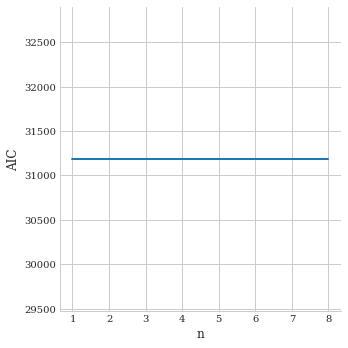

In [108]:
sns.relplot(x="n", y="AIC", data=searchresults, kind="line")

* When AIC ( or any other model metric) remains same across two models, we don't have a sufficient basis to prefer one model over the other.  So if exhaustive search yields similar AIC scores, we need some other basis (e.g., a theoretical logic) to prefer one model over the other. 

* Sex/gender is a dominant variable across all models.

In [117]:
df1.describe()

,sex,race,sexharass,smoking,vegetables,soda,breakfast,computer,sleepcat,racecat_white
count,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000,36220.000000
mean,1.481336,2.064633,1.186554,1.250028,2.556102,2.410574,5.098896,3.930204,0.248150,0.615130
std,0.499658,1.226763,0.631294,0.988877,1.360694,1.490681,2.657106,2.191636,0.431945,0.486571
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,5.000000,4.000000,0.000000,1.000000
75%,2.000000,3.000000,1.000000,1.000000,3.000000,3.000000,8.000000,6.000000,0.000000,1.000000
max,2.000000,4.000000,5.000000,7.000000,7.000000,7.000000,8.000000,7.000000,1.000000,1.000000


In [120]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36220 entries, 0 to 36219
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   sex            36220 non-null  int64
 1   race           36220 non-null  int64
 2   sexharass      36220 non-null  int64
 3   smoking        36220 non-null  int64
 4   vegetables     36220 non-null  int64
 5   soda           36220 non-null  int64
 6   breakfast      36220 non-null  int64
 7   computer       36220 non-null  int64
 8   sleepcat       36220 non-null  int64
 9   racecat_white  36220 non-null  uint8
dtypes: int64(9), uint8(1)
memory usage: 2.5 MB


The model without the sexual harassment variable seems to tbe best performing model. The AIC score is a straight line.

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

#### Backward elimination of variables
* We start with the "full" model and elimiate in steps the least useful predictor according to statistical significance. 
* The elimination stops when all the remaining predictors make significant contributions to the model.

In [109]:
def train_model(variables):
    model = sklm.LogisticRegression(solver='liblinear')
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X2.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: sex, sexharass, smoking, vegetables, soda, breakfast, computer, racecat_white
Start: score=31184.71
Step: score=31184.71, remove None
['sex', 'sexharass', 'smoking', 'vegetables', 'soda', 'breakfast', 'computer', 'racecat_white']


In [110]:
classificationSummary(valid_y2, best_model.predict(valid_X2[best_variables]))

Confusion Matrix (Accuracy 0.7483)

       Prediction
Actual     0     1
     0 10842     0
     1  3646     0


<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

#### Forward selection
* We start with the "null" model and keep adding predictors one-by-one. 
* Each added predictor wil be the one that makes the largest contribution to the R-squared value.
* The algorithm stops when additional predictors dont make significant contribution.

In [111]:
train_X.columns

Index(['const', 'sex', 'sexharass', 'smoking', 'vegetables', 'soda',
       'breakfast', 'computer', 'racecat_white'],
      dtype='object')

In [112]:
AIC_score(train_y, [train_y.mean()*0] * len(train_y), model, df=1)

31182.712470527134

In [113]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = sklm.LogisticRegression(solver='liblinear')
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()*0] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: const, sex, sexharass, smoking, vegetables, soda, breakfast, computer, racecat_white
Start: score=31182.71, constant
Step: score=31182.71, add None
[]


<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

#### Stepwise selection
* It works like forward selection, but we drop variables that are not statistically significant at each step (similar to backward elimination).

In [115]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: const, sex, sexharass, smoking, vegetables, soda, breakfast, computer, racecat_white
Start: score=31182.71, constant
Step: score=31182.71, unchanged None
[]


* No variable is selected in forward selectio and stepwise selection, meaning the base model (i.e., just the average or the naive prediction) turns out to be better than a model with more variables. That is, there is no valuable information (in terms of prediction) to be gained from adding variables.  

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id8'></a>
### <span style="background-color:#B0E0E6">Regularization in Logit</span>
* The solvers handle the penalties to help with regularization. Refer to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* ‘liblinear’ and ‘saga’ handle L1 penalty
* newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 and no penalty

In [357]:
# split into training and validation
logitcv = sklm.LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logitcv.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [358]:
# confusion matrix
classificationSummary(valid_y, logitcv.predict(valid_X))

Confusion Matrix (Accuracy 0.7483)

       Prediction
Actual     0     1
     0 10842     0
     1  3646     0


In [359]:
print("Classification Report:\n",classification_report(valid_y, logitcv.predict(valid_X)))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86     10842
           1       0.00      0.00      0.00      3646

    accuracy                           0.75     14488
   macro avg       0.37      0.50      0.43     14488
weighted avg       0.56      0.75      0.64     14488



C:\Users\edwar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


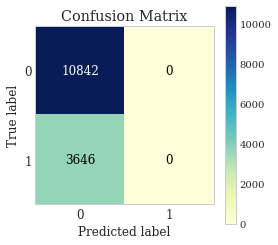

In [360]:
skplt.metrics.plot_confusion_matrix(valid_y, logitcv.predict(valid_X), figsize=(4,4), cmap="YlGnBu")

* regularization regression also suggests base model (i.e., just the average or the naive prediction) turns out to be better.  

<div style="text-align: right"> <a href='#section_id0'>Back to top of Notebook</a></div>

<a id='section_id11'></a>
### <span style="background-color:#B0E0E6">References:</span>

* Chapter 10 of _Datamining for Business Analytics_. [Access through Pitt library](https://pitt.summon.serialssolutions.com/#!/search?bookMark=ePnHCXMw42JgAfZbU5khpymBDxSztADNrHEZgbYtA2tc0K0CXMBq3gRYkwA7SJwMSi6JJYkKueALERSATTUF6P2LxQqJoIM5QMcV8zCwpgGjI5WXgaWkqBRYcEq7uYY4e-iCDkeKhw50xAPTkpmJBejiIfyyKlhkYXM9QGVA95qYGQMA-383uA)
* Another book I like is: [Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/). The ISL book provides intuitive and "math-lite" explanations for many concepts. 
    * The ISL book uses "R for lab exercises," but the concepts covered are independent of the programming language.
    * [The videos](https://www.dataschool.io/15-hours-of-expert-machine-learning-videos/) from the authors of the ISL book are a great resource.
    * Another book, [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/), has more advanced treatment of the topics covered by ISL.

***

<font color="#610B21"><center>\~\~ End of Part-3. We'll discuss KNN in Part-4\~\~ </center>
<font color="#0B610B"><center>\*\* **See you later!**\*\* </center>
***